In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve,\
                                                        precision_score, recall_score, f1_score,roc_curve,auc,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict,StratifiedKFold
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
# import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
# from collections import Counter
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from models import cross_val_pr_curve,tune_hyperparameters

In [2]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [3]:
print(X_train_processed)

       num__fico  num__amtfinanced_1req  num__pti_1req  num__ltv_1req  \
0      -0.991736               0.302313       1.185841       0.078676   
1       0.049587              -0.305787      -0.700885      -0.058040   
2      -0.099174               0.007061      -0.350442       0.248065   
3       0.909091              -0.493473      -0.975221      -2.340499   
4      -0.578512              -0.964168      -1.056637       1.594583   
...          ...                    ...            ...            ...   
21601  -0.132231               0.513574      -0.364602       0.053740   
21602  -1.024793              -0.803701      -0.329204       0.317283   
21603  -1.008264              -0.574447       2.107929       0.149613   
21604   0.371901              -0.941448      -1.044248       0.613500   
21605   0.685950               1.426664      -0.065487      -0.367584   

       num__p12_bcx7110_a  num__p12_all7170_a  num__p12_aut7110_a  \
0                1.000000                 3.0         

In [4]:
# Train Logistic Regression model with statsmodels (Logit and Logit)
X_train_sm = sm.add_constant(X_train_processed)


logit_model = sm.Logit(y_train, X_train_sm)
result_logit = logit_model.fit()
print("Statsmodels Logit Summary:")
print(result_logit.summary())


Optimization terminated successfully.
         Current function value: 0.411197
         Iterations 7
Statsmodels Logit Summary:
                           Logit Regression Results                           
Dep. Variable:              aprv_flag   No. Observations:                21606
Model:                          Logit   Df Residuals:                    21579
Method:                           MLE   Df Model:                           26
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                  0.2846
Time:                        11:03:11   Log-Likelihood:                -8884.3
converged:                       True   LL-Null:                       -12419.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
con

In [5]:
# remove feature that are not significant according to P-value
X_train_processed_filtered_pvalue=X_train_processed.loc[:,(result_logit.pvalues<=0.05)[1:].values]

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i)
                          for i in range(len(X_train_sm.columns))]

print(vif_data)

                                              feature       VIF
0                                               const  6.644077
1                                           num__fico  3.454782
2                               num__amtfinanced_1req  1.421209
3                                       num__pti_1req  1.301027
4                                       num__ltv_1req  1.187631
5                                  num__p12_bcx7110_a  1.587802
6                                  num__p12_all7170_a  1.270044
7                                  num__p12_aut7110_a  1.122480
8                                  num__p12_all7120_a  1.561043
9                                  num__p12_bcc8120_a  1.315445
10                                 num__p12_iln7410_a  1.572816
11                                 num__p12_all8150_a  1.083699
12                                 num__p12_all7517_a  1.335070
13                                 num__p12_iln8220_a  2.031464
14                                 num__

In [6]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'fit_intercept':[True,False],
    'class_weight':['balanced']
}

best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,LogisticRegression(),'average_precision')

print("Best Hyperparameters for Logistic Regression:", best_params)


Best Hyperparameters for Logistic Regression: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


In [7]:
# Train Logistic Regression model with best hyperparameters
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.92187803 0.92456334 0.92596943]
Mean Precision Score: 0.9241369344807259
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      5654
           1       0.90      0.75      0.82     15952

    accuracy                           0.76     21606
   macro avg       0.71      0.76      0.72     21606
weighted avg       0.80      0.76      0.77     21606



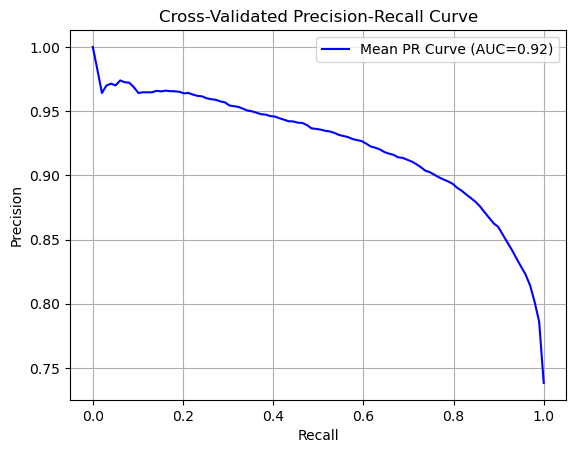

Mean Precision-Recall AUC: 0.9241


In [8]:
from models import evaluate_models
evaluate_models(log_reg, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was f

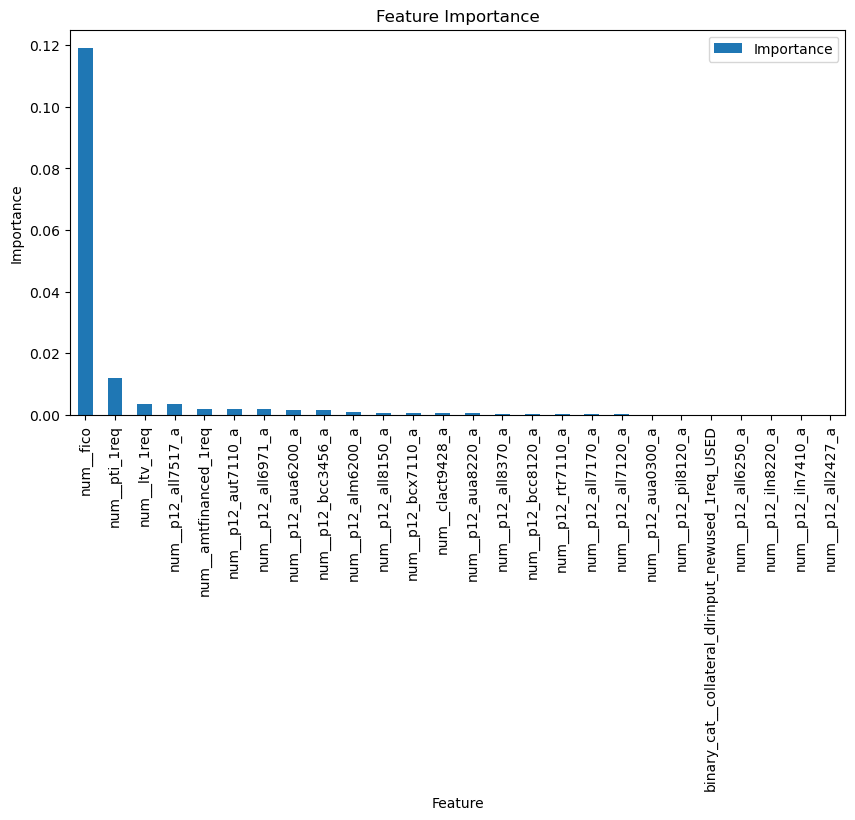

In [9]:
from models import feature_importance
feature_importance(log_reg, X_train_processed, y_train,'average_precision')